In [1]:
import numpy as np
from EM import EM
from plot import plot
import matplotlib.pyplot as plt

In [2]:
signal_name = 'creatinine'

treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['nephrotoxic_drugs'] = ['acetaminophen_dose','celecoxib_dose','diclofenac_dose','ibuprofen_dose',
                                        'indomethacin_dose','ketorolac_dose','meloxicam_dose',
                                        'naproxen_dose', 'aminoglycoside', 'radiographic']
treatment_names['interference_drugs'] = ['dronedarone_dose', 'trimethoprim_dose']
treatment_names['diuretic'] = ['eplerenone_dose', 'amiloride_dose', 'hydrochlorothiazide_dose',
'spironolactone_dose', 'triamterene_dose', 'chlorothiazide_dose', 'indapamide_dose', 'torsemide_dose', 
'acetazolamide_dose', 'mannitol_dose']
treatment_names['ace_i'] = ['lisinopril_dose',
 'ramipril_dose',
 'benazepril_dose',
 'enalaprilat_dose',
 'captopril_dose',
 'perindopril_dose',
 'trandolapril_dose']
treatment_names['arb'] = ['valsartan_dose',
 'telmisartan_dose',
 'irbesartan_dose',
 'losartan_dose',
 'candesartan_dose']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'sickle_cell', 'renal', 'esrd', 'diabetes', 'heart_failure']

demographic_names = ['age', 'gender', 'admit_weight']

In [3]:
# EM Setting
num_past_effects = 4
training_pct = .8
single_effect = False

In [4]:
data = np.load('../Data/'+signal_name+'_preprocessed_data.npz')

In [5]:
%%time
em = EM(data['y_mtx'], data['X_mtx'], data['c_mtx'], num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
        X_prev = data['X_prev_mtx'], single_effect=single_effect)
em.run_EM(2000)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
50 iterations before loglik converges
CPU times: user 1min 10s, sys: 15.7 ms, total: 1min 10s
Wall time: 1min 10s


In [11]:
for i, treatment in enumerate(treatment_names.keys()):
    print('Coefficient for {}: {}'.format(treatment, em.A[:, i]))
static_types = chronic_keywords + demographic_names
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, em.b[j]))
print('initial state variance: {}'.format(em.sigma_0))
print('transition noise: {}'.format(em.sigma_1))
print('observation noise: {}'.format(em.sigma_2))

Coefficient for dialysis: [1.28773183 0.67709006 1.69277825 0.07461059]
Coefficient for nephrotoxic_drugs: [ 0.29195822  0.19672653 -0.00960085  0.13673952]
Coefficient for interference_drugs: [-1.01251069  0.86239904 -0.86858685  0.49170673]
Coefficient for diuretic: [-0.25792532 -0.14592139 -0.20146574 -0.15859482]
Coefficient for ace_i: [-0.54774024 -0.49759226 -0.07691473 -0.14734275]
Coefficient for arb: [0.33739117 0.4711431  0.58222959 0.20901732]
Coefficient for chronic_kidney: -0.3205745413512688
Coefficient for kidney_cancer: 1.5668927001048647
Coefficient for sickle_cell: -0.676447090370744
Coefficient for renal: -0.15013620140544556
Coefficient for esrd: 0.4907455682283015
Coefficient for diabetes: 0.14205325145165584
Coefficient for heart_failure: -0.07958493560739828
Coefficient for age: 0.009061279022645726
Coefficient for gender: 0.0640167093565463
Coefficient for admit_weight: 0.007408175362608992
initial state variance: 0.004968258987004847
transition noise: 0.4241219

* Seems right
    * dialysis: large decrease, decreasing effect
    * kidney condition, sickle cell, renal insufficiency all positive
    * esrd: large positive (too large?)
    * gender: if 1 is male, more muscle mass, should be positive
* Not sure
    * nephrotoxic: small but all negative, should be positive
    * heart failure has some correlation w/ ckf, could be explained away?
    * diuiretic, ace_i, arb: smaller effects, but should be positive
    * interference drug: decrease, then reversible increase, as much as .4-.5

~2400 patients, bin size = 12

Coefficient for dialysis: [-1.25244691 -0.91004053 -0.21459075 -0.42475535]
Coefficient for nephrotoxic_drugs: [-0.08090726 -0.07991469 -0.0475412  -0.05704326]
Coefficient for interference_drugs: [-0.51968216  0.55852061 -0.5975565   0.45760547]
Coefficient for diuretic: [-0.03709144 -0.0906244  -0.00982771  0.00633813]
Coefficient for ace_i: [-0.1398929  -0.07606301  0.00553438 -0.05486874]
Coefficient for arb: [ 0.04790997  0.05916514  0.04554519 -0.02649363]
Coefficient for chronic_kidney: 1.3276992153677334
Coefficient for kidney_cancer: 0.4657241447060389
Coefficient for sickle_cell: 0.6944110901583288
Coefficient for renal: 0.36938015275431246
Coefficient for esrd: 4.979872491291173
Coefficient for diabetes: -0.011392474077059327
Coefficient for heart_failure: -0.10725797416111006
Coefficient for age: -0.010595353250786524
Coefficient for gender: 0.33801674162950984
Coefficient for admit_weight: -0.00391452359659601
initial state variance: 0.002450611017498509
transition noise: 0.3092411529988513
observation noise: 1.1462685855189954

~4900 patients, bin size = 18
Coefficient for dialysis: [-0.84369415 -0.20670296 -0.19209145 -0.12898347]
Coefficient for nephrotoxic_drugs: [ 0.0061965  -0.01760545 -0.03195994 -0.03811994]
Coefficient for interference_drugs: [ 0.08539192 -0.02559257 -0.0150296   0.28703508]
Coefficient for diuretic: [-0.0839336  -0.01663768 -0.03398865 -0.00229813]
Coefficient for ace_i: [-0.04267848 -0.03589504 -0.03006326  0.00650137]
Coefficient for arb: [-0.06834566  0.01926409 -0.02665397 -0.06530141]
Coefficient for chronic_kidney: 1.07540830272662
Coefficient for kidney_cancer: 0.22747302073201697
Coefficient for sickle_cell: 0.2978642268283123
Coefficient for renal: 0.2359794919131614
Coefficient for esrd: 4.243433886976185
Coefficient for diabetes: 0.007339300575137738
Coefficient for heart_failure: -0.2302044935520313
Coefficient for age: 0.0069989306726437606
Coefficient for gender: 0.25778374601214377
Coefficient for admit_weight: 0.008944466618056438
initial state variance: 0.0033114086040231102
transition noise: 0.20750738614923198
observation noise: 0.7733703877264095

In [12]:
good_examples=[771, 776]

Patient 60


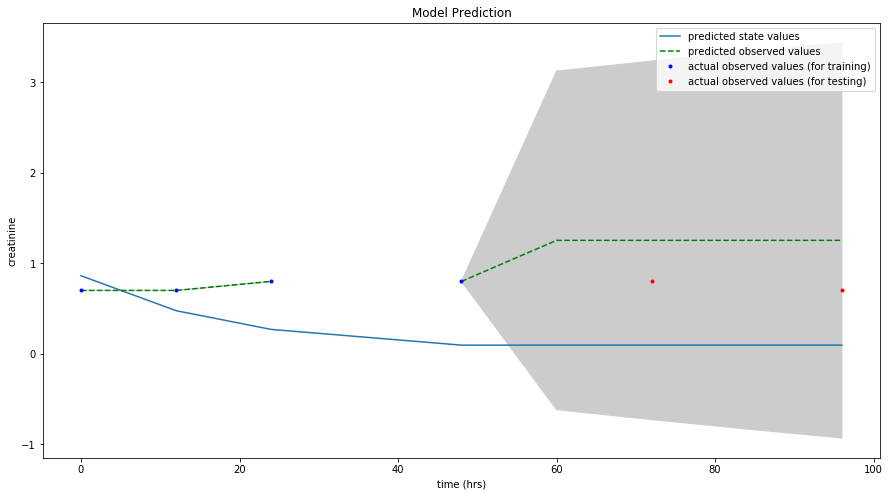

Patient 128


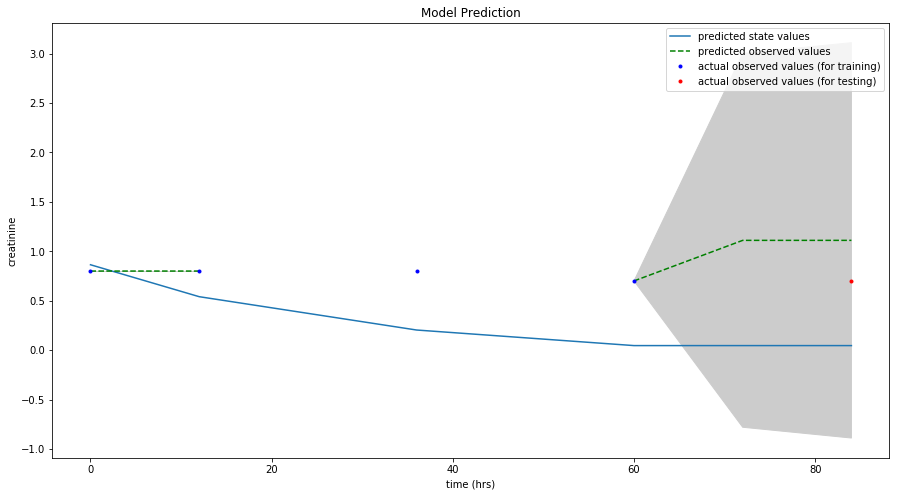

Patient 222


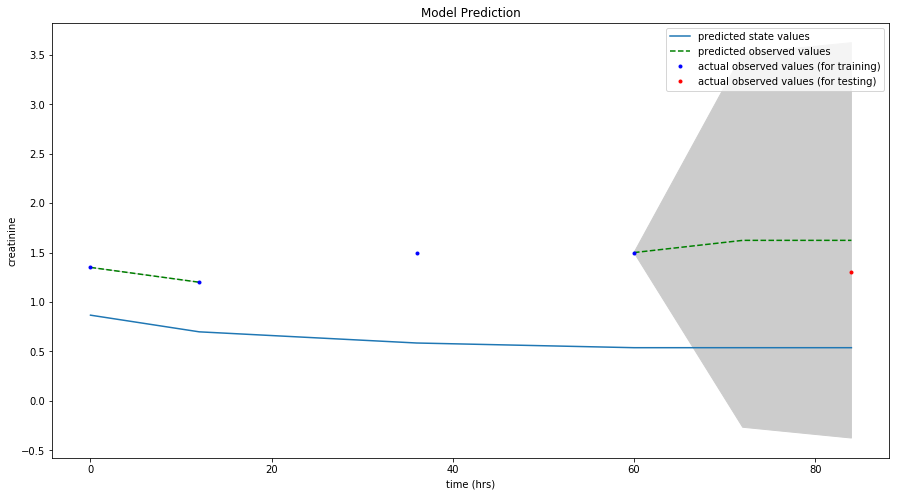

Patient 383


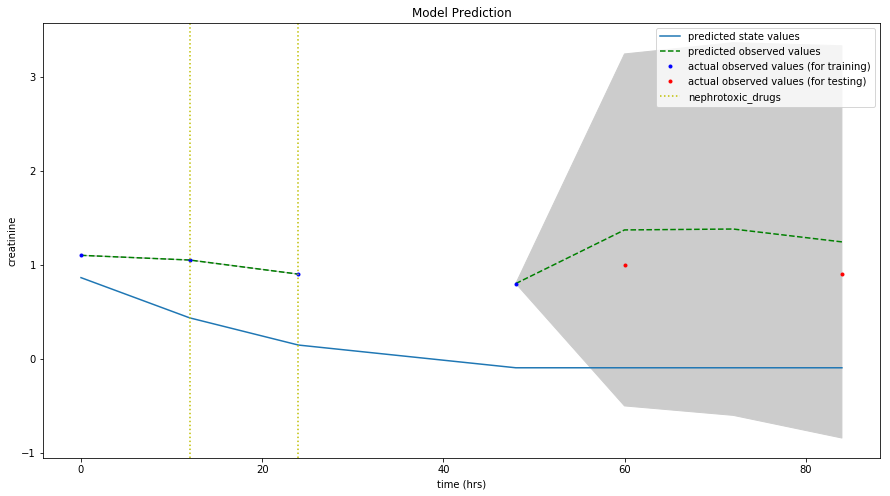

Patient 185


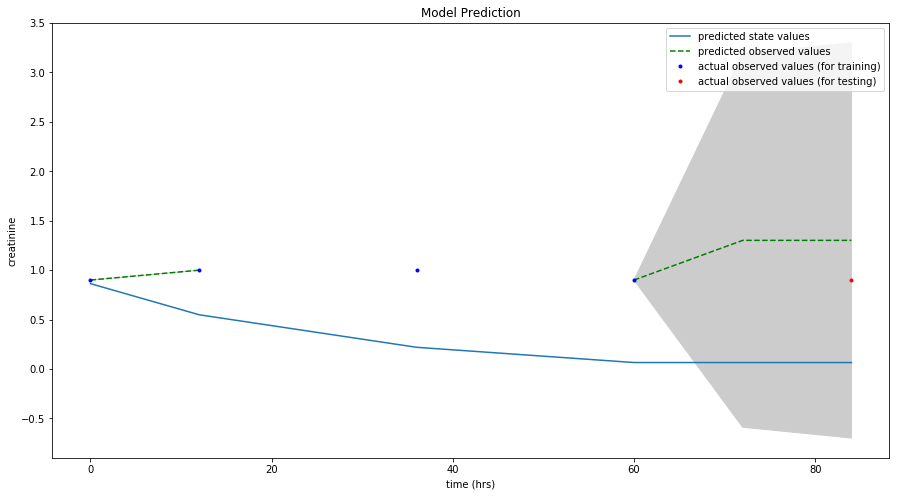

Patient 150


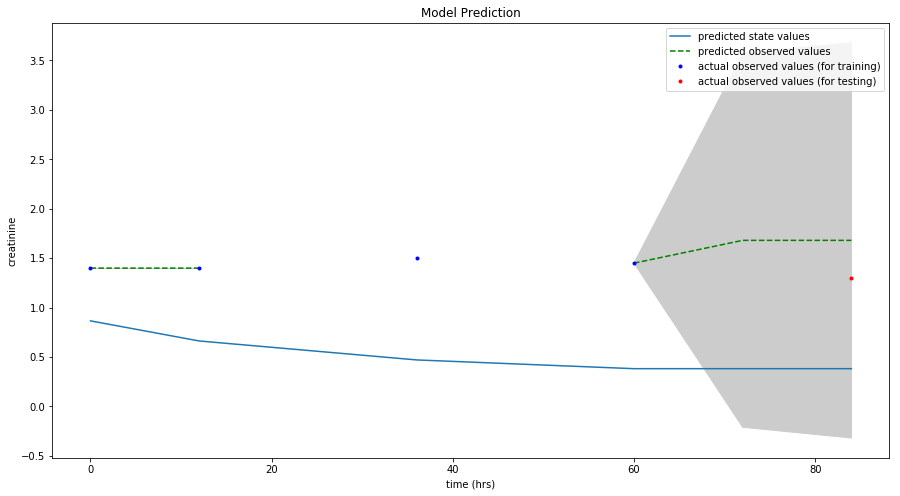

Patient 14


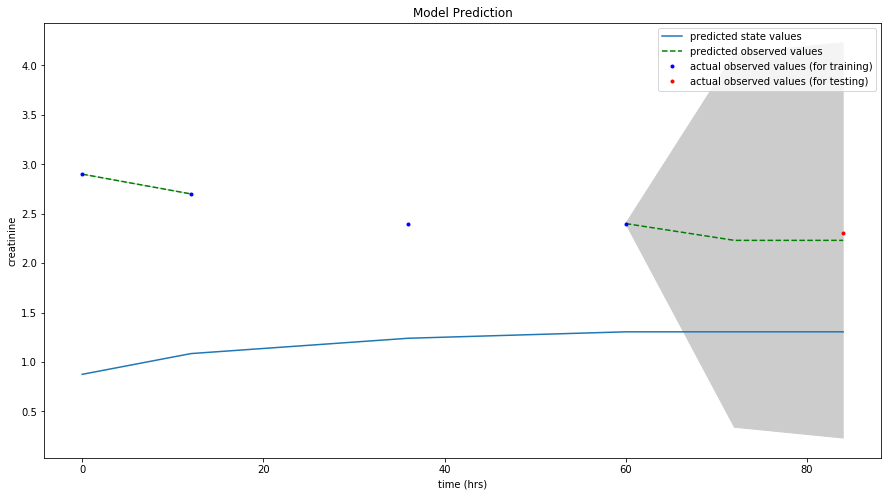

Patient 30


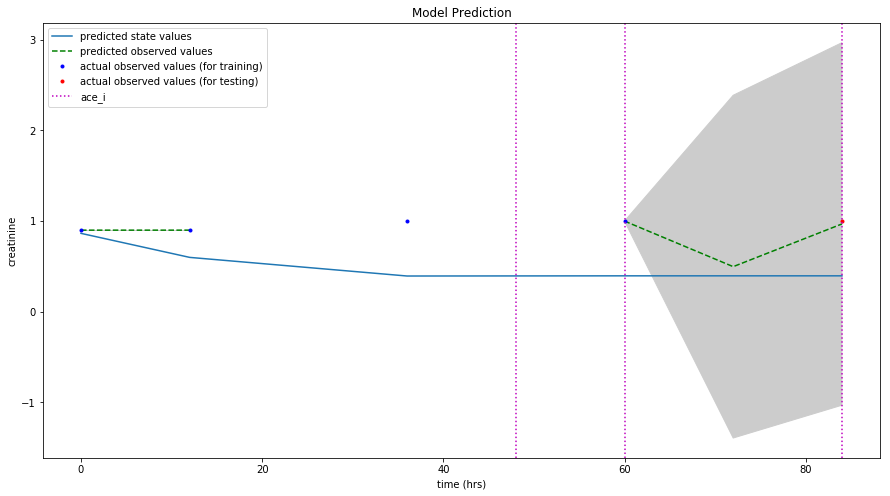

Patient 73


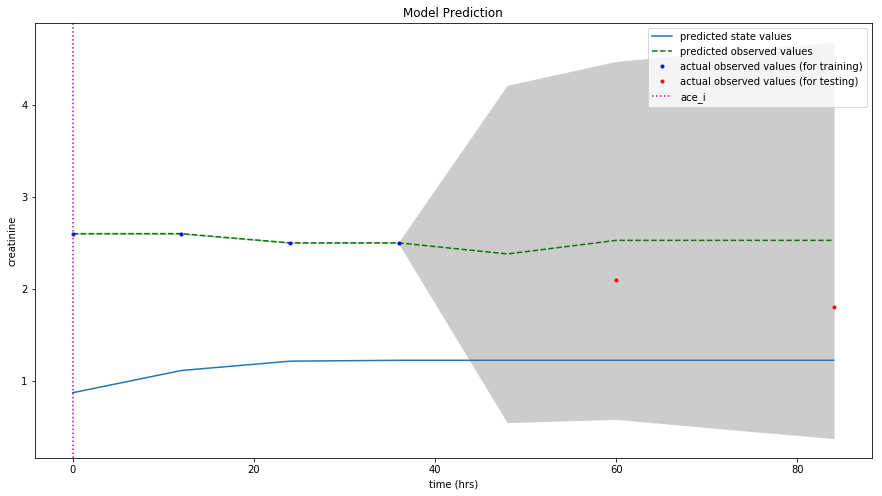

Patient 35


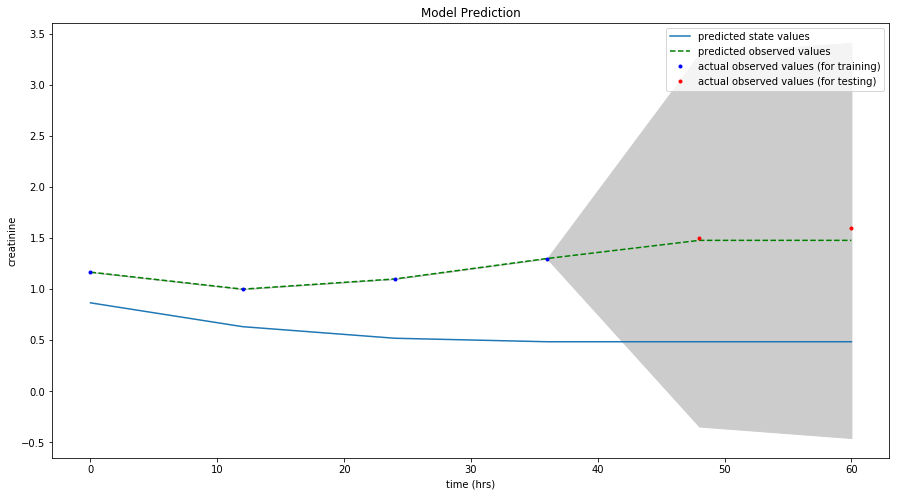

In [13]:
random_patients = np.random.randint(0, em.y.shape[0], 10)
for i in random_patients:
    plot(em, i, 12, signal_name, treatment_types=list(treatment_names.keys()))

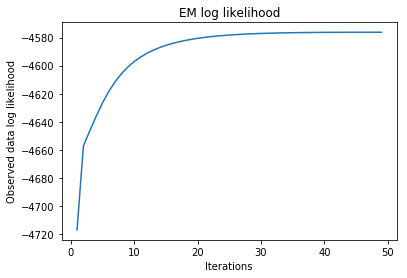

In [9]:
plt.plot([i for i in range(1, len(em.obs_log_lik))], em.obs_log_lik[1:])
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

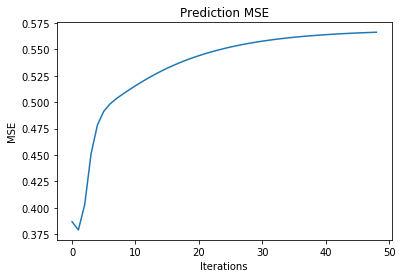

In [10]:
plt.plot([i for i in range(len(em.mse))], em.mse)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Prediction MSE')
plt.show()

### Analysis
Changes
* Only select patients with at least 4 training observations (total of 1821)

On real data
* Issues:
    * treatments coefficients are negative while they should be positive
        * changing initialization doesn't seem to help as model converges in bad local min, and most directions still don't change
    * observation noise is bigger than transition noise
    * run time is long, each iteration takes 4s, M step takes 2.5s, loglik takes 1s
* Reasons:
    * The increasing effects of treatments are not pronouced in the data (see Source Data Analysis)
        * it makes sense that nsaid and aspirin shows small number close to zero since their effects are 50-50.
        * transfusion platelet should be more negative than others, also makes sense.
        * the first number for plasma is a very negative number, but should be close to zero
        * anticoagulant are more negative than platelet, but should be more similar
    * bad noise estimation is expected, specifically underestimated initial state variance and overestimated observational noise 
    
On simulation
* Issues
    * b seems to be harder to identify correctly compared to A (sensitive to initialization)
    * estimated sigma 0 and sigma 2 are very different from the true value (not sensitive to initialization)
        * underestimate sigma 0, overestimate sigma 2
* Reasons
   

2000 iterations (haven't converged, 2nd decimal place different) took 2hrs
Coefficient for nsaid: [-0.05332823  0.01914507 -0.03836663]
Coefficient for transfusion_plasma: [-0.694217   -0.03495779 -0.0522998 ]
Coefficient for transfusion_platelet: [-0.38430565 -0.15892385 -0.31262086]
Coefficient for anticoagulant: [-0.63994745 -0.74545805 -0.5791365 ]
Coefficient for aspirin: [-0.06409683 -0.06972851  0.0302996 ]
Coefficient for chronic kidney failure: -0.2643214568560729
Coefficient for sickle cell: -0.5218307359528491
Coefficient for age: -0.027047728916270067
initial state variance: 0.00020395166620667873
transition noise: 0.14622894241670079
observation noise: 1.127059127544025